# The SearchTweets.py file searches twitter for a term, pulls the tweets, scores their sentiment with the VADER text analysis package, and writes the tweets to a database. I've pulled some tweets for the terms Trump, Happy, and Disgusting. In this notebook I'll explore the data we've pulled, and see how the VADER text analysis scores tweets.

### First we need to connect to the database and pull data from a given table. Pandas makes this really easy

In [1]:
#importing relevant packages
import pandas as pd
import sqlalchemy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#function to pull table
def PullTable(table_name, table_loc):
    try:
        connection = sqlalchemy.create_engine('sqlite:///' + table_loc).connect()
        results = pd.read_sql_table(table_name, con = connection)
        print('pulled table {}'.format(table_name))
    except:
        print('failed to pull data')
    finally:
        connection.close()
        
    return(results)

In [3]:
HappyTweets = PullTable(table_name = 'HappyTweetsScored', table_loc =  'D:\\Github\\Twitter_Analysis\\Data\\Tweets.db')
DisgustingTweets = PullTable(table_name = 'DisgustingTweetsScored', table_loc =  'D:\\Github\\Twitter_Analysis\\Data\\Tweets.db')
TrumpTweets =  PullTable(table_name = 'TrumpTweetsScored', table_loc =  'D:\\Github\\Twitter_Analysis\\Data\\Tweets.db')

pulled table HappyTweetsScored
pulled table DisgustingTweetsScored
pulled table TrumpTweetsScored


### Since I didn't have training data I pulled some tweets relating to tweets that should be biased towards positive (search term Happy) and negative (search term Disgusting) sentiment.

In [4]:
HappyTweets['Group'] = 'Happy'
DisgustingTweets['Group'] = 'Disgusting'
TrumpTweets['Group'] = 'Trump'
CombinedDF = pd.concat([HappyTweets,DisgustingTweets, TrumpTweets], axis = 0)

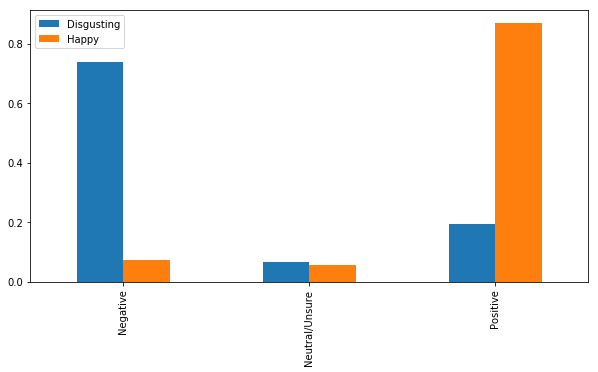

In [5]:
plotdata = pd.DataFrame({'Happy': HappyTweets.Sentiment.value_counts()/len(HappyTweets),
                       'Disgusting': DisgustingTweets.Sentiment.value_counts()/len(DisgustingTweets)
                        })
plotdata.plot.bar(figsize = (10,5))


Group
Disgusting    AxesSubplot(0.125,0.125;0.775x0.755)
Happy         AxesSubplot(0.125,0.125;0.775x0.755)
Name: compound_score, dtype: object

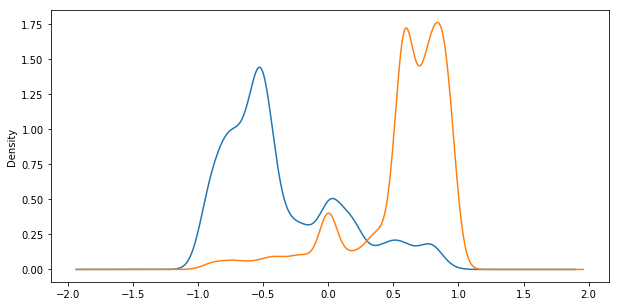

In [6]:
CombinedDF[CombinedDF.Group.isin(['Happy','Disgusting'])].groupby('Group').compound_score.plot.density(figsize = (10,5))

### We can see from the above two plots that the tweets that were under the search term "Happy" are almost all scored as positve. And the tweets under the search term "Disgusting" are mostly scored negative. However, ~20 % are still positive, which could be due to mis-scoring or due to the tweets actually being positive. This is an important distinction to make, since it could bias results when comparing the number of positive to negative tweets in  subsequent analyses. 

In [7]:
for tweet in DisgustingTweets.sort_values('compound_score',ascending=False).TweetText.unique()[:10]:
    print(tweet + '\n')

Like I really like feeling sexy and comfortable in the body I have and I am not ashamed to show it. Then I get sham…  

RT  : I know so many truly gorgeous beautiful straight women who are currently in love with objectively disgusting looking tras…

  ❝Waving! You were waving! All joyful as if you're so happy to be alive. It's disgusting.❞ 

G l a r e s.

RT  : Drew said Jason came back and “derailed” his happy little family. It’s like this man would be perfectly fine if he never fou…

 _titties Broadside’s entire Paradise album also, but especially the title track and I Love You, I Love You, It’s Disgusting

    Super hero? I would hope the rappers turned on Trump because they realized he's a racist,…  

  FOR THE LOVE SEAN!!! PLEASE, I BEG YOU AS A DEVOTED VIEWER STOP GIVING THE #MSM AIRTIME ON YOUR SHOW,…  

(fucK twilight is so good uGH I DIDN'T WATch it for like a MONTH? and now i am? and it's SO GOOD WHY WOULD I NOT WA…  

that pic is DISGUSTING LOL, but i love you sooooo soooo m

### Examining the tweets it does seem like some of these are actually positive. I'd need to actually score a large number of them accross the whole range of scores to figure out the accuracy. Overall, though the VADER sentiment analyzer does seem to be mostly scoring things as one would expect.

### I've also collected tweets from a more ambiguous search term for which people are likely tweeting both positive and negative statements about -- Trump. Let's see the breakdown

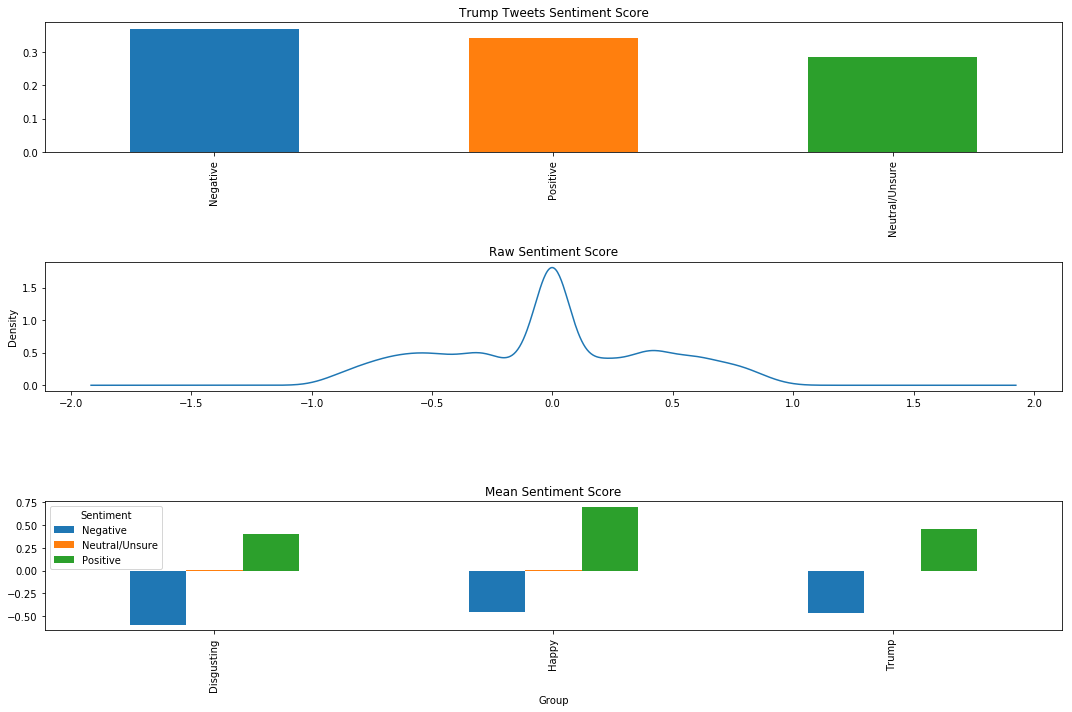

In [8]:
fig, ax = plt.subplots(3,1)
TrumpTweets.Sentiment.value_counts(normalize = True).plot.bar(title = 'Trump Tweets Sentiment Score', figsize = (10,5), ax = ax[0])
TrumpTweets.compound_score.plot.density(title = 'Raw Sentiment Score', figsize = (10,5), ax = ax[1])
CombinedDF.groupby(['Group','Sentiment']).compound_score.mean().unstack().plot.bar(title = 'Mean Sentiment Score', figsize = (10,5), ax = ax[2])
fig.set_figheight(10)
fig.set_figwidth(15)
plt.tight_layout()


### Compared to the Happy and Disgusting tweets, Trump tweets are much more ambiguous. There is a much large amount of neutral/unsure tweets, and positive and negative tweets within the Trump tweets have a much flatter distribution with mean values that are less extreme. There are slightly more negative than positive tweets, though it is close. 

### Let's see what else we can explore

In [9]:
TrumpTweets.columns

Index(['ID', 'Datetime', 'Language', 'IsRetweet', 'AuthorScreenName',
       'AuthorFollowersCount', 'AuthorLocation', 'AuthorTimeZone',
       'TweetFavoriteCount', 'TweetText', 'neg_score', 'neutral_score',
       'pos_score', 'compound_score', 'Sentiment', 'Group'],
      dtype='object')

### We have access to whether or not the tweet is a retweet, the number of times the tweet has been favorited, and some information on the author such as their follower count and location. Let's see if any of these are related to sentiment scores for Trump related tweets.

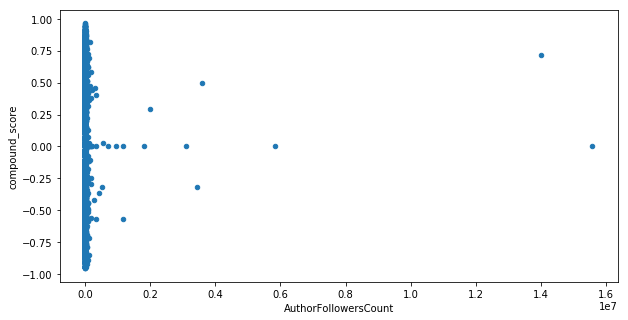

In [10]:
TrumpTweets.plot.scatter(x = 'AuthorFollowersCount', y = 'compound_score', figsize = (10,5))

### Major outliers -- let's plot things we can actually see.

In [11]:
TrumpTweets.AuthorFollowersCount.quantile(.95)

12864.099999999999

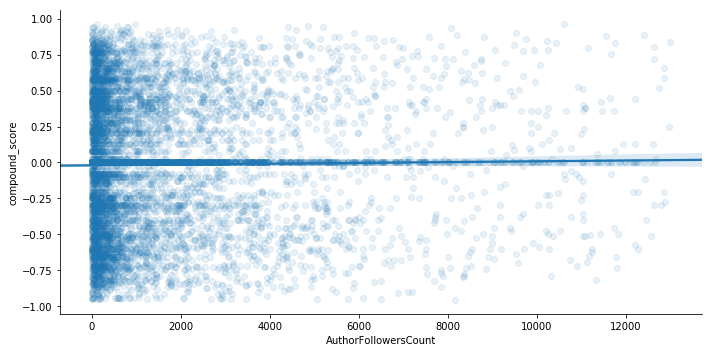

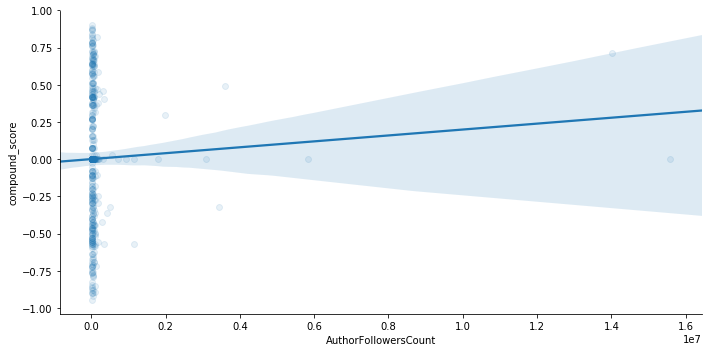

In [12]:
sns.lmplot(data = TrumpTweets[TrumpTweets.AuthorFollowersCount < 13000] , x = 'AuthorFollowersCount', y = 'compound_score',
           scatter_kws={'alpha':0.1}, size = 5, aspect = 2) # no real trend
sns.lmplot(data = TrumpTweets[TrumpTweets.AuthorFollowersCount >= 13000] , x = 'AuthorFollowersCount', y = 'compound_score',
           scatter_kws={'alpha':0.1}, size = 5, aspect = 2) # no real trend even for large follower counts

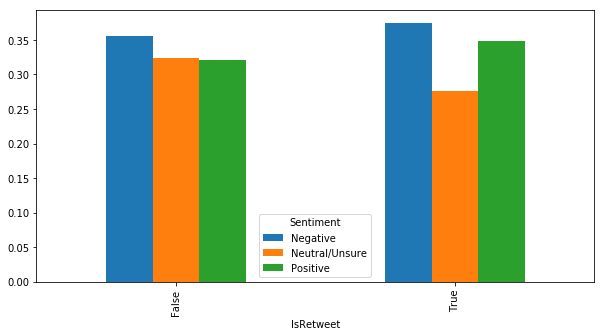

In [13]:
TrumpTweets.IsRetweet = TrumpTweets.IsRetweet.astype(bool)
TrumpTweets.groupby('IsRetweet').Sentiment.value_counts(normalize = True).unstack().plot.bar(figsize = (10,5))

In [14]:
from scipy.stats import chi2_contingency

In [15]:
_, p, _, _ = chi2_contingency(TrumpTweets.groupby('IsRetweet').Sentiment.value_counts().unstack().as_matrix())
print(p) # These are different populations - it looks like retweets are less likely to be neutral

0.0003413474869966053


In [16]:
TrumpTweets.TweetFavoriteCount.unique()

array([0, 1, 2, 4, 5], dtype=int64)

In [17]:
TrumpTweets.groupby('TweetFavoriteCount').Sentiment.value_counts() # almost all are not favorited, not worth analyzing

TweetFavoriteCount  Sentiment     
0                   Negative          3321
                    Positive          3078
                    Neutral/Unsure    2553
1                   Negative            15
                    Positive            15
                    Neutral/Unsure      11
2                   Negative             2
                    Neutral/Unsure       2
4                   Negative             2
5                   Positive             1
Name: Sentiment, dtype: int64

In [18]:
TrumpTweets.AuthorLocation.value_counts()[:10]

                   2901
United States       350
California, USA     156
USA                 115
Texas, USA           96
Florida, USA         78
Los Angeles, CA      55
Washington, DC       47
New York, USA        42
New York, NY         35
Name: AuthorLocation, dtype: int64

### I wanted to analyze sentiment by location, however in twitter this is difficult because people manually type in their location, so variations of the same location do not share the same name. To do this correctly would require significant effort in data cleaning. Instead I'll look at time zone entires which are much less varied (though still not perfect)

In [19]:
TrumpTweets.AuthorTimeZone.value_counts()[:20]

Pacific Time (US & Canada)     1337
Eastern Time (US & Canada)      963
Central Time (US & Canada)      600
Mountain Time (US & Canada)     144
Quito                           132
Arizona                         109
Atlantic Time (Canada)          105
London                          101
America/New_York                 71
America/Chicago                  48
America/Los_Angeles              48
Hawaii                           47
Amsterdam                        40
Alaska                           25
Paris                            16
Sydney                           15
Tehran                           15
Athens                           12
Dublin                           11
Melbourne                        10
Name: AuthorTimeZone, dtype: int64

In [20]:
TrumpTweets.AuthorTimeZone.dropna()[TrumpTweets.AuthorTimeZone.dropna().str.contains('America')].value_counts()

America/New_York       71
America/Chicago        48
America/Los_Angeles    48
America/Detroit         6
America/Denver          5
America/Phoenix         5
Central America         3
America/Mexico_City     2
America/Vancouver       2
America/Anchorage       2
America/Edmonton        2
America/Toronto         2
America/Caracas         1
America/Resolute        1
America/Montevideo      1
Name: AuthorTimeZone, dtype: int64

In [21]:
#some minor recategorizing of time zones with significant counts
TrumpTweets.AuthorTimeZone.loc[TrumpTweets.AuthorTimeZone == 'America/New_York'] = 'Eastern Time (US & Canada)'
TrumpTweets.AuthorTimeZone.loc[TrumpTweets.AuthorTimeZone == 'America/Chicago'] = 'Eastern Time (US & Canada)'
TrumpTweets.AuthorTimeZone.loc[TrumpTweets.AuthorTimeZone == 'America/Los_Angeles'] = 'Pacific Time (US & Canada)'
TrumpTweets.AuthorTimeZone.loc[TrumpTweets.AuthorTimeZone == 'America/Phoenix'] = 'Pacific Time (US & Canada)'
TrumpTweets.AuthorTimeZone.loc[TrumpTweets.AuthorTimeZone == 'America/Detroit'] = 'Eastern Time (US & Canada)'
TrumpTweets.AuthorTimeZone.loc[TrumpTweets.AuthorTimeZone == 'Arizona'] = 'Eastern Time (US & Canada)'
TrumpTweets.AuthorTimeZone.loc[TrumpTweets.AuthorTimeZone == 'Atlantic Time (Canada)'] = 'Eastern Time (US & Canada)'

C:\Users\Bober\Anaconda2\envs\py36\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### Now let's look at the breakdown from the 4 US & Canada timezones

In [22]:
LocationsToAnalyze = TrumpTweets.AuthorTimeZone.value_counts()[0:4]

AuthorTimeZone
Central Time (US & Canada)     AxesSubplot(0.125,0.125;0.775x0.755)
Eastern Time (US & Canada)     AxesSubplot(0.125,0.125;0.775x0.755)
Mountain Time (US & Canada)    AxesSubplot(0.125,0.125;0.775x0.755)
Pacific Time (US & Canada)     AxesSubplot(0.125,0.125;0.775x0.755)
Name: compound_score, dtype: object

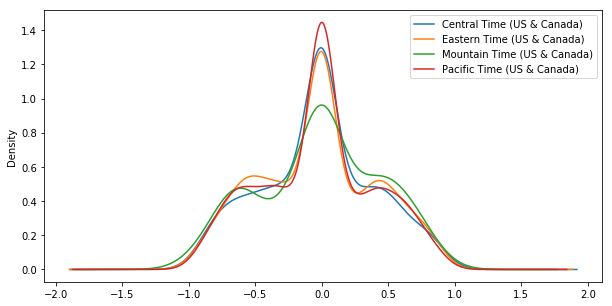

In [23]:
TrumpTweets.loc[TrumpTweets.AuthorTimeZone.isin(LocationsToAnalyze.index)].groupby('AuthorTimeZone').compound_score.plot.density(figsize = (10,5), legend = 'AuthorTimeZone')

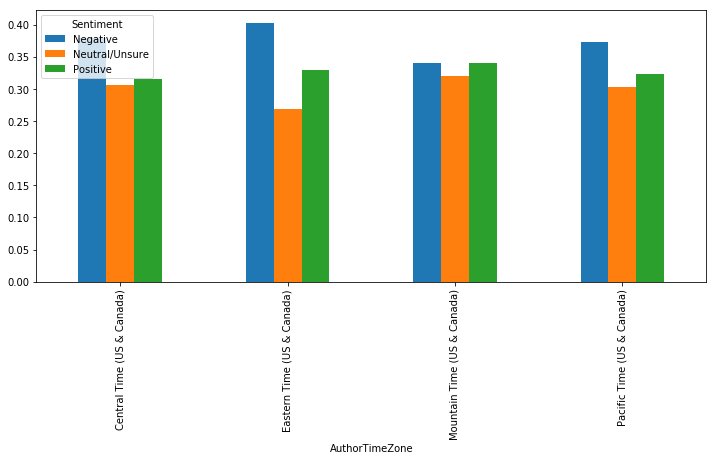

In [24]:
TrumpTweets.loc[TrumpTweets.AuthorTimeZone.isin(LocationsToAnalyze.index)].groupby('AuthorTimeZone').Sentiment.value_counts(normalize = True).unstack().plot.bar(figsize = (12,5))

### Interestingly, twitter sentiment on Trump in US & Canada does not seem to vary heavily by time zone.